In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install biopython
!pip install prettytable

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 15.6 MB/s eta 0:00:00


In [3]:
"""
class vocab processor to
    features - sequence length frequency dictionary

    methods -
        seqLenFrequency - analyse sequence length distribution through training and testing set, generate sequence length distribution graph
        seqToCSV - converting txt data into a csv file
        mergeCSVnClean - to merge positive and negative csv files to create single csv file and remove sequences that exceeds the maximum length of 1000
"""

class VocabProcessor:

    seq_len_freq = {}   # storing seq len frequency

    def __init__(self, file_path = None):
        handle = open(file_path, "r")   # opening tsv file
        self.data_file = handle # storing as a object variable

    def seqLenFrequency(self):
        import matplotlib.pyplot as plt
        import seaborn as sns

        for line in self.data_file:
            line = line.strip().split("\t")
            seq = line[1] # line has id and sequence
            key = len(seq)

            # classifying sequences according to length and storing in the dictionary - length range as key and count as value
            if key <= 200:
                if "0-200" not in self.seq_len_freq.keys():
                    self.seq_len_freq["0-200"] = 1
                else:
                    self.seq_len_freq["0-200"] += 1

            if key > 200 and key <= 400:
                if "200-400" not in self.seq_len_freq.keys():
                    self.seq_len_freq["200-400"] = 1
                else:
                    self.seq_len_freq["200-400"] += 1

            if key > 400 and key <= 600:
                if "400-600" not in self.seq_len_freq.keys():
                    self.seq_len_freq["400-600"] = 1
                else:
                    self.seq_len_freq["400-600"] += 1

            if key > 600 and key <= 800:
                if "600-800" not in self.seq_len_freq.keys():
                    self.seq_len_freq["600-800"] = 1
                else:
                    self.seq_len_freq["600-800"] += 1

            if key > 800 and key <= 1000:
                if "800-1000" not in self.seq_len_freq.keys():
                    self.seq_len_freq["800-1000"] = 1
                else:
                    self.seq_len_freq["800-1000"] += 1

            if key > 1000:
                if ">1000" not in self.seq_len_freq.keys():
                    self.seq_len_freq[">1000"] = 1
                else:
                    self.seq_len_freq["800-1000"] += 1

        # plotting in pie chart
        palette_color = sns.color_palette('bright')
        plt.pie(self.seq_len_freq.values(), labels = self.seq_len_freq.keys(), colors=palette_color, autopct='%.0f%%')
        plt.show()


    def seqToCSV(self, label ,output_path): # intended label and name of output file
        import csv  # class to create csv files

        output = open(str(output_path), "w")    # opening output file object
        writer = csv.writer(output)
        fields = ["length", "amino acids", "label"] # defining fileds in csv file
        writer.writerow(fields)
        for line in self.data_file: # iterate through lines in given input txt file from constructor
            line = line.strip().split("\t")
            seq = " ".join(line[1]) # gapping between amino acids
            writer.writerow([len(line[1]), seq, label]) # writing length, sequence and label for each sequence
        output.close()

    @staticmethod
    def mergeCSVnClean(trf_file, non_trf_file): # two files to be merged
        import pandas as pd

        trf_df = pd.read_csv(trf_file)  # reading both csv files
        ntrf_df = pd.read_csv(non_trf_file)
        dataset = pd.concat([trf_df, ntrf_df], ignore_index = True) # merging
        dataset.dropna(inplace=True)    # removing blank rows
        dataset = dataset[dataset["length"] < 1000] # dropping sequences than exceed the maximum length of 1000
        return dataset


In [4]:
"""
class vectorizer
    fields -
        data frame - to store merged csv file as a variable
        vocab - to store different amino acids and counts for feature selection
        features - number of amino acids after feature selection
        clean_seq - sequences after feature selection

    methods -
        seqAnalyse - counting frequency of each amino acid in raw sequences and saving as a dictionary in vocab
        removeMiniFeatures - go through raw sequences, reducing dimensions, storing cleaned sequences in clean_seq as a dictionary
        oneHotEncodingPadding - call remove miniFeatures method, save number of amino acids after feature selection in features field,
                                max length = 1000
                                one hot encoding the sequences using hashing trick method
                                adding paddings to encoded sequences

"""
class Vectorizer:

    def __init__(self, dataFrame):
        self.dataFrame = dataFrame  # store raw sequences
        self.vocab = None # store amino acids in raw sequences
        self.features = None  # store number of amino acids after feature selection
        self.clean_seq = None # store sequences after feature selection

    def seqAnalayse(self):
        from collections import Counter # save unique amino acids in data

        dataset = self.dataFrame
        dataset.dropna(inplace=True)
        seqs = dataset["amino acids"]
        counter = Counter()
        for seq in seqs:
            counter.update(str(seq).split())
        self.vocab = counter
        print("Number of different amino acids : ", len(self.vocab.keys()))
        print("Number of sequence records : ", seqs.shape[0])

    def removeMiniFeatures(self):
        from collections import Counter # save unique amino acids in data

        counter = Counter()
        aa_counts = self.vocab
        raw_seq = self.dataFrame.iloc[:, 1] # isolate sequences from raw data frame
        clean_seq = []  # store dimension reduced sequence
        maxlen = 0  # to store the maximum length of sequences in dataset
        for seq in raw_seq:
          new_seq = ""  # store new seq in each iteration
          for aa in seq:
            if aa_counts[aa] > 4000:  # remove amino acids that is less than 4000 in total in dataset
              new_seq += aa
          if len(new_seq) > maxlen:
            maxlen = len(new_seq)
          new_seq = " ".join(new_seq) # add gaps b/w amino acids in seq for encoding
          clean_seq.append(new_seq)
        for seq in clean_seq: # processing sequence data after dimension reduction
            counter.update(str(seq).split())
        self.features = len(counter.keys())
        self.clean_seq = clean_seq
        print("Amino acids after feature selection : ", self.features)
        print("Max length of seq : ", maxlen)
        return clean_seq

    def oneHotEncodingPadding(self):
        from keras.preprocessing.text import hashing_trick  # one hot encoding
        from keras.preprocessing.sequence import pad_sequences # padding seqs

        seq_list = self.removeMiniFeatures()  # call dimension reduction method
        features = self.features #20
        max_len = 1000  # set maximum possible length for prediction to 1000
        hashed = [hashing_trick(seq, n=features, hash_function="md5", split=" ") for seq in seq_list]
        pad_seq = pad_sequences(hashed, max_len, padding="post")
        # print(pad_seq)
        return pad_seq



In [5]:
# merge csv files of positive and negative data set
csv = VocabProcessor.mergeCSVnClean("/content/drive/MyDrive/Colab Notebooks/trf_len_seq_label.txt",
                                    "/content/drive/MyDrive/Colab Notebooks/non_trf_len_seq_label.txt")
print(csv["amino acids"])
print(csv["label"])

0      M A G L P R R I I K E T Q R L L A E P V P G I ...
1      M A L K R I N K E L S D L A R D P P A Q C S A ...
2      M E R P E E G K Q S P P P Q P W G R L L R L G ...
4      M M A G C G E T D H S I N M L P T N R K A N E ...
5      M A S G I L L N V K E E V T C P I C L E L L T ...
                             ...                        
708    M A T Q R K H L V K D F N P Y I T C Y I C K G ...
709    M A I T L E E A P W L G W L L V K A L M R F A ...
710    M A K P L T D S E K R K Q I S V R G L A G L G ...
712    M A T Q R K H L V K D F N P Y I T C Y I C K G ...
713    M S G W P R I Y Y K L L N L P L S I L V K S K ...
Name: amino acids, Length: 654, dtype: object
0      1
1      1
2      1
4      1
5      1
      ..
708    0
709    0
710    0
712    0
713    0
Name: label, Length: 654, dtype: int64


Number of different amino acids :  22
Number of sequence records :  654
Counter({'L': 30380, 'S': 22493, 'A': 21877, 'E': 21687, 'G': 19325, 'V': 19113, 'R': 17723, 'K': 17174, 'P': 16450, 'D': 16158, 'T': 15585, 'I': 15070, 'Q': 13673, 'N': 12707, 'F': 11932, 'Y': 9600, 'H': 8198, 'M': 7296, 'C': 7293, 'W': 4396, 'U': 3, 'X': 2})


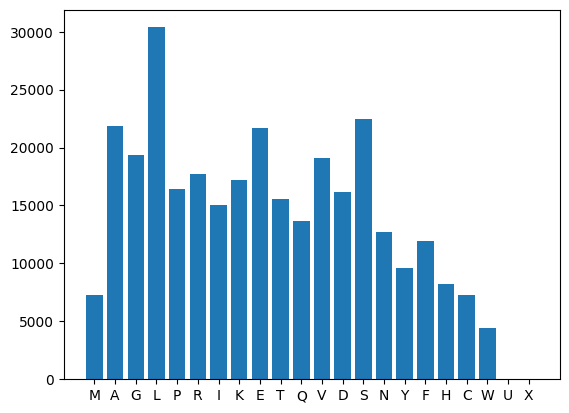

In [6]:
"""
create vectorizer object using merged csv file
seq analyse method calling
plot amino acids frequency in dataset in histogram
"""
vectorized = Vectorizer(csv)
vectorized.seqAnalayse()
print(vectorized.vocab)
data = vectorized.vocab
names = list(data.keys())
values = list(data.values())
import matplotlib.pyplot as plt
plt.bar(range(len(data)), values, tick_label=names)
plt.show()


In [8]:
# encoding seqs
encoded = vectorized.oneHotEncodingPadding()
print(encoded)
labels = vectorized.dataFrame["label"]

Amino acids after feature selection :  20
Max length of seq :  975
[[12 14 10 ...  0  0  0]
 [12 14  9 ...  0  0  0]
 [12 19 10 ...  0  0  0]
 ...
 [12 14 18 ...  0  0  0]
 [12 14  9 ...  0  0  0]
 [12  4 10 ...  0  0  0]]


In [ ]:
# train test split
from sklearn.model_selection import train_test_split

seqTrain, seqTest, labelTrain, labelTest = train_test_split(encoded, labels, test_size=0.2, random_state=0)

In [ ]:
print(labelTrain.value_counts())

0    265
1    258
Name: label, dtype: int64


([<matplotlib.patches.Wedge at 0x7c566d929840>,
 [Text(-0.023124779451135377, 1.0997569024904261, '0'),
  Text(0.023124779451135, -1.0997569024904261, '1')])

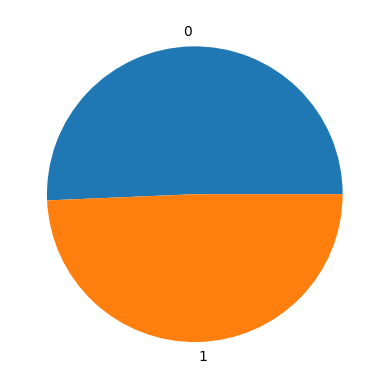

In [ ]:
# checking balance of classes using a pie chart
import matplotlib.pyplot as plt
import numpy as np

plt.pie(np.array([labelTrain.value_counts()[0], labelTrain.value_counts()[1]]), labels=[0, 1])

1    265
0    265
Name: label, dtype: int64


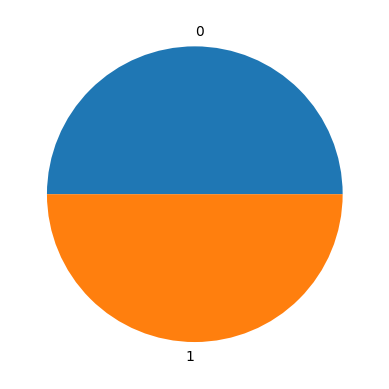

In [ ]:
# remove class imbalance and visualize with pie chart
from imblearn.over_sampling import SMOTE

smote = SMOTE()
seqTrain, labelTrain = smote.fit_resample(seqTrain, labelTrain)
plt.pie(np.array([labelTrain.value_counts()[0], labelTrain.value_counts()[1]]), labels=[0, 1])
print(labelTrain.value_counts())

In [ ]:
from tensorflow.keras.models import Sequential
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from keras.layers import Attention
from sklearn.model_selection import train_test_split
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers.legacy import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LeakyReLU
from keras.models import load_model

In [ ]:
# architecture of model
"""
layers - 5
loss function - binary cross entropy
regularizer - L2
optimizer - adam
"""
model = Sequential()

model.add(Embedding(20, 15, input_length=1000))

model.add(Bidirectional(LSTM(units=10, return_sequences=True, recurrent_regularizer="l2")))

model.add(Flatten())

model.add(LeakyReLU())

model.add(Dense(1, activation='sigmoid',kernel_regularizer='l2'))

model.compile(loss=BinaryCrossentropy(from_logits=True), optimizer=Adam(learning_rate=0.001, decay=0.001), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 15)          300       
                                                                 
 bidirectional (Bidirection  (None, 1000, 20)          2080      
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 20000)             0         
                                                                 
 dense (Dense)               (None, 1)                 20001     
                                                                 
Total params: 22381 (87.43 KB)
Trainable params: 22381 (87.43 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [ ]:
"""
callabacks -
    earlystopping - prevent overfitting
    model checkpoint - save best model while training
    checkpoint criteria - testing accuracy
"""
# traning the model
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/best.keras'
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
history = model.fit(seqTrain, labelTrain, validation_data=(seqTest, labelTest), epochs=30, batch_size=32, callbacks=[model_checkpoint_callback, earlystop], verbose=1)


In [ ]:
# plotting the validation curves and learning curves
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (6,6))
ax.plot(history.history['loss'])
ax.set_xlabel("Number of Iterations")
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.plot(history.history['val_loss'])
ax.legend(['train loss', 'train acc', 'val acc', 'val loss'])
plt.show()

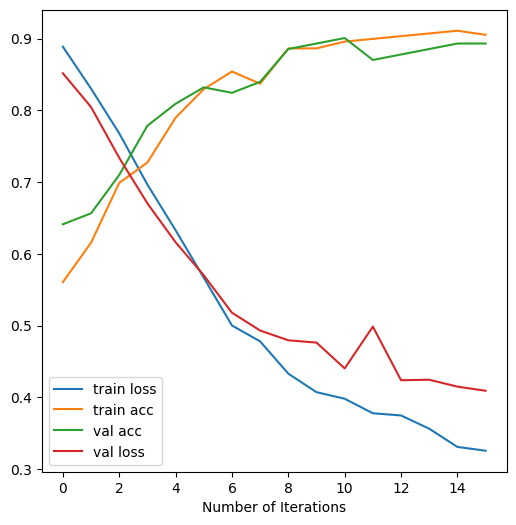

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/rat_model.keras')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 15)          300       
                                                                 
 bidirectional (Bidirection  (None, 1000, 20)          2080      
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 20000)             0         
                                                                 
 dense (Dense)               (None, 1)                 20001     
                                                                 
Total params: 22381 (87.43 KB)
Trainable params: 22381 (87.43 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import numpy as np

predicted = model.predict(seqTest)  # predict on testing data
predicted = np.reshape(predicted, (-1)) # convert 2d array of probabilities of into 1D array
actual = np.reshape(labelTest, (-1))  # actual labels in 1d array

5/5 [==============================] - 1s 93ms/step


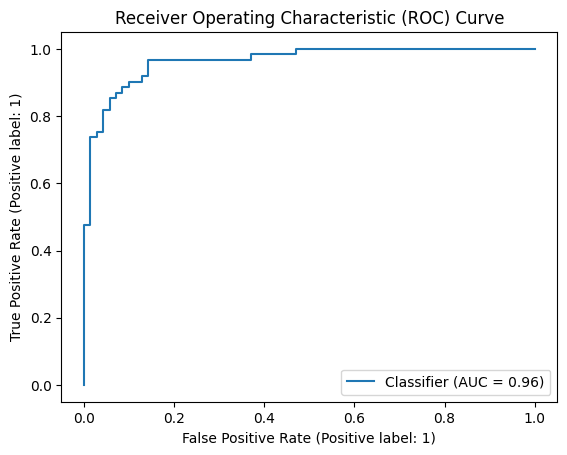

In [ ]:
# plotting ROC curve
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, DetCurveDisplay

RocCurveDisplay.from_predictions(actual, predicted)
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

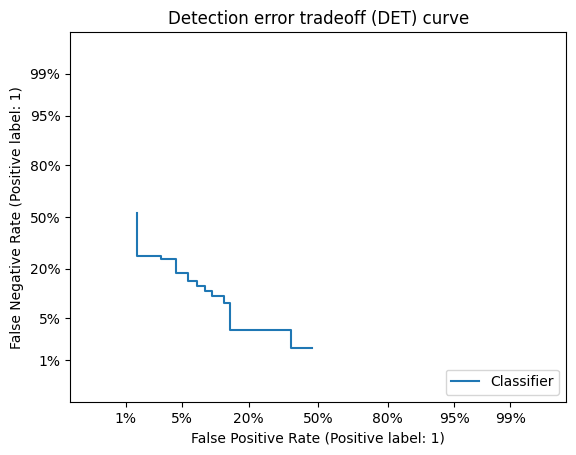

In [ ]:
# plotting DET curve
DetCurveDisplay.from_predictions(actual, predicted)
plt.title("Detection error tradeoff (DET) curve")
plt.show()

In [ ]:
# calculating best threshold using ROC curve
"""
criteria for best threshold
  the threshold that has maximum difference between tpr and fpr
"""
fpr, tpr, thresholds = roc_curve(actual, predicted)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

Threshold value is: 0.31482762


In [ ]:
# converting predicted probabilities into binary labels according to best threshold
binary_label = []
for sig_val in predicted:
  if sig_val > optimal_threshold:
    binary_label.append(1)
  else:
    binary_label.append(0)

print(binary_label)

[0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1]


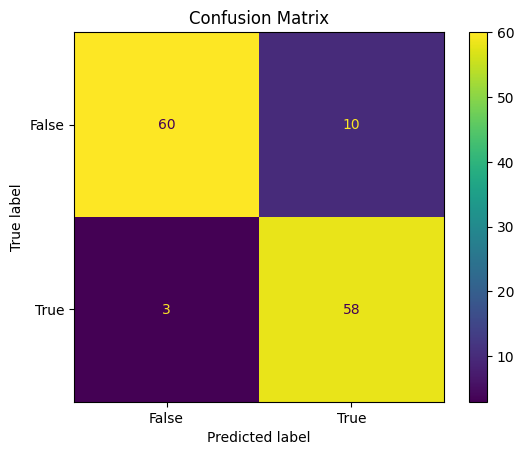

In [ ]:
# plotting confusion matrix from predicted labels and actual lables
visualize = ConfusionMatrixDisplay.from_predictions(actual, binary_label, display_labels=[False, True])
plt.title('Confusion Matrix')
plt.show()

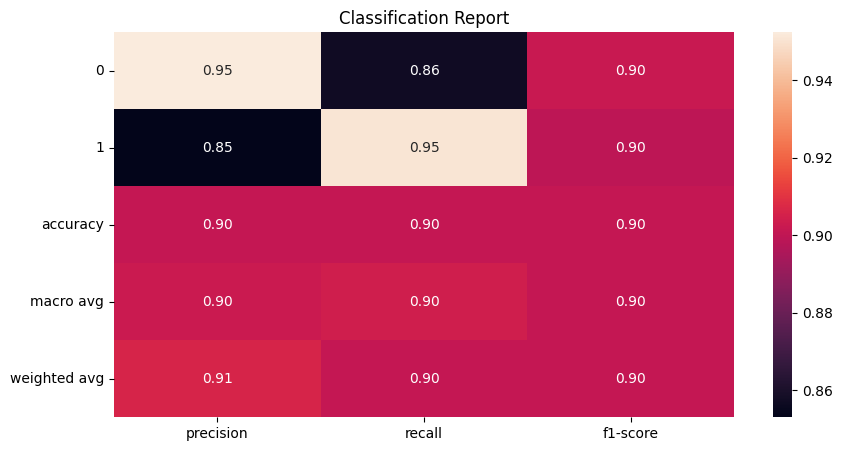

In [ ]:
# classification report
import seaborn as sns
import pandas as pd

cl_rep = classification_report(actual, binary_label, output_dict=True)
report_df = pd.DataFrame(cl_rep).transpose()
plt.figure(figsize=(10, 5))
sns.heatmap(report_df.drop(['support'], axis=1), annot=True, fmt=".2f")
plt.title('Classification Report')
plt.show()

In [11]:
"""
class predictor

  fiels -
    recs - dictioary of input fasta sequences (key - fasta header, value - raw sequence)
    new recs - dictionary of inouts after feature selection (key - fasta header, value - raw sequence)

  methods -
    parse fasta - import seqio module from biopython, parse the records in fasta file, store in recs
    remove mini features - dimension reduction by removing U and X form seqs, skipping seqs that are larger than 1000
    encode seq - one hot encoding seqs
    show results - retrieve predicted probabilities as a list
                    import pretty table
                    create output table
                    generate labels using optimal threshold and probabilities
                    append predictions to tabel as fasta header and class

    predict class - take fasta file as input
                    call parse fasta
                    call remove mini features
                    call encode seq
                    call show results
"""
class Predictor:
    def __init__(self, file):
        self.file = file
        self.recs = dict()
        self.new_recs = dict()

    def parseFasta(self):
        from Bio import SeqIO

        for record in SeqIO.parse(self.file, 'fasta'):
            key = record.id
            value = record.seq
            self.recs[key] = value

    def removeMiniFeatures(self):
        for id, seq in self.recs.items():
            new_seq = ''
            for aa in seq:
                if aa not in ["U", "X"]:
                    new_seq += aa

            if len(new_seq) > 1000:
                print("The recored of ID : ", id, "exceeds the maximum possible length")
                print("\tskipping record ", id)
                continue

            else:
                new_seq = " ".join(new_seq)
                self.new_recs[id] = new_seq

    def encodeSeq(self):
        from keras.preprocessing.text import hashing_trick
        from keras.preprocessing.sequence import pad_sequences

        voc_size = 20
        max_len = 1000
        hashed = [hashing_trick(seq, n=voc_size, hash_function="md5", split=" ") for seq in self.new_recs.values()]
        pad_seq = pad_sequences(hashed, max_len, padding="post")
        return pad_seq

    def showResults(self, labels):
        from prettytable import PrettyTable
        import itertools

        table = PrettyTable()
        table.field_names = ['Record', 'Class']
        threshold = 0.31482762
        for (header, p_val) in zip(self.new_recs.keys(), labels):
          if p_val >= threshold:
            fn = "Ubiquitin transferase"
          else:
            fn = "Non-ubiquitin transferase"

          table.add_row([header, fn])
        print(table)


    def predictClass(self):
        import numpy as np
        from keras.models import load_model

        self.parseFasta()
        self.removeMiniFeatures()
        pad_seq = self.encodeSeq()
        model = load_model("/content/drive/MyDrive/Colab Notebooks/rat_model.keras")
        predicted = model.predict(pad_seq)
        predicted = np.reshape(predicted, (-1))
        self.showResults(predicted)


In [12]:
unknown = Predictor("/content/drive/MyDrive/Colab Notebooks/unknown.fasta")
unknown.predictClass()

1/1 [==============================] - 1s 751ms/step
+-------------------------+---------------------------+
|          Record         |           Class           |
+-------------------------+---------------------------+
|  sp|P06104.1|UBC2_YEAST |   Ubiquitin transferase   |
|  sp|P15731.1|UBC4_YEAST |   Ubiquitin transferase   |
|  sp|P15732.1|UBC5_YEAST |   Ubiquitin transferase   |
|  sp|P53924.1|DMA2_YEAST |   Ubiquitin transferase   |
| sp|Q84TG3.1|PUB23_ARATH |   Ubiquitin transferase   |
|  sp|Q6NLQ8.1|XB32_ARATH |   Ubiquitin transferase   |
|  sp|Q9LT17.1|BBR_ARATH  |   Ubiquitin transferase   |
|  sp|Q06834.2|ASR1_YEAST | Non-ubiquitin transferase |
|  sp|Q4FE45.1|XB33_ARATH |   Ubiquitin transferase   |
| sp|P80912.2|HINT1_RABIT |   Ubiquitin transferase   |
|  sp|Q861Y3.1|ANGI_RHIRO |   Ubiquitin transferase   |
|  sp|Q861Y4.1|ANGI_TRAFR |   Ubiquitin transferase   |
|  sp|Q65XS5.1|BC10_ORYSJ | Non-ubiquitin transferase |
|  sp|Q6R311.1|AAT2_MALDO | Non-ubiquitin transfera